# Eurozone CPI, ECB Deposit Facility, Marginal Lending Facility rates, Market Yield on Government Bonds at 10-Year, and Eurozone Riskless Yield Curve
This notebook jaxteposes the evolution of Eurozone CPI with ECB Deposit Facility Rate and 10 year Government Bond yields. It also looks at the evolution of the Euro riskless rate curve as defined by the yields on AAA-rated eurozone central government bonds.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthBegin
from pandas.tseries.offsets import BDay

from datetime import date
import re

from dateutil.relativedelta import relativedelta

from pricing import curves

In [2]:
report_start = date.fromisoformat('1996-01-01')
report_end = date.today()

### Get Consumer Price Index for Eurozone (19 countries), ECB Deposit Facility Rate, and 10 Year Government Bond Yields
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `CP0000EZ19M086NEST` &mdash; Harmonized Index of Consumer Prices: All Items for Euro area (19 countries) (monthly frequency, from 1996)
* `ECBDFR` &mdash; ECB Deposit Facility Rate for Euro Area (daily frequency, from 1999)
* `ECBMLFR` &mdash; ECB Marginal Lending Facility Rate for Euro Area (daily frequency, from 1999)
* `IRLTLT01DEM156N` &mdash; Long-Term Government Bond Yields: 10-year Germany (monthly frequency, from 1960)
* `IRLTLT01ITM156N` &mdash; Long-Term Government Bond Yields: 10-year Italy (monthly frequency, from 1960)

And the following dataseries provided by the [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `irt_lt_mcby_m` &mdash; EMU convergence criterion series (monthly frequency). This series returns a MultiIndexed dataset containing Long-Term Government Bond Yields for the Eurozone at 10-year maturity. I use it instead of the `IRLTLT01DEM156N` and `IRLTLT01ITM156N` datasets returned by FRED given that Eurostat's datbase tends to be updated earlier than that of FRED for Eurozone data.

In [3]:
cpi_ecbr_irtlt = web.get_data_fred(['CP0000EZ19M086NEST', 'IRLTLT01DEM156N', 'IRLTLT01ITM156N'], start=report_start, end=report_end)
ecbr = web.get_data_fred(['ECBDFR', 'ECBMLFR'], start=report_start, end=report_end)

# Make frequencies explicit, resample to month srart
cpi_ecbr_irtlt = cpi_ecbr_irtlt.asfreq('MS')
ecbr = ecbr.asfreq('D').resample('MS').last()

# Since CP0000EZ19M086NEST is indexed to 2015=100, we need to convert it to annual percentage changes
cpi_ecbr_irtlt.update(cpi_ecbr_irtlt.CP0000EZ19M086NEST.pct_change(12)*100)

# Merge and truncate to start of celendar year 1999.
cpi_ecbr_irtlt = pd.concat([cpi_ecbr_irtlt, ecbr], axis=1).loc['1999':]

cpi_ecbr_irtlt = cpi_ecbr_irtlt[['CP0000EZ19M086NEST', 'ECBDFR', 'ECBMLFR', 'IRLTLT01DEM156N', 'IRLTLT01ITM156N']]

DE_YIELD_LABEL = '10y German Government Bond Yield'
IT_YIELD_LABEL = '10y Italian Government Bond Yield'
cpi_ecbr_irtlt.rename(
    columns={'CP0000EZ19M086NEST': 'Annual Eurozone CPI',
             'ECBDFR': 'ECB Deposit Facility Rate', 'ECBMLFR': 'ECB Marginal Lending Facility Rate',
             'IRLTLT01DEM156N': DE_YIELD_LABEL,
             'IRLTLT01ITM156N': IT_YIELD_LABEL},
    inplace=True)

In [4]:
# Since FRED's database is updated less frequently for Eurozone data than that of Eurostat
# retrieving the most recent government bond yields from Eurostat's database
EUROSTAT_DE_COUNTRY_LABEL = 'Germany (until 1990 former territory of the FRG)'
EUROSTAT_IT_COUNTRY_LABEL = 'Italy'
eu_irt_lt = web.DataReader('irt_lt_mcby_m', 'eurostat', start=report_start, end=report_end)
eu_irt_lt = eu_irt_lt.sort_index(axis=1).loc[:, ('EMU convergence criterion bond yields',
                              [EUROSTAT_DE_COUNTRY_LABEL, EUROSTAT_IT_COUNTRY_LABEL])].droplevel([0,2], axis=1)
eu_irt_lt.rename(
    columns={EUROSTAT_DE_COUNTRY_LABEL: DE_YIELD_LABEL,
             EUROSTAT_IT_COUNTRY_LABEL: IT_YIELD_LABEL},
    inplace=True)

# Override last year's data with Eurostat's values
cpi_ecbr_irtlt.loc['2022':, [DE_YIELD_LABEL, IT_YIELD_LABEL]] = eu_irt_lt.loc['2022':]

# Calculate a mean rate for the current month
eu_irt_lt_cur_mth = web.DataReader('irt_lt_mcby_d', 'eurostat', start=cpi_ecbr_irtlt.index[-1].date())
eu_irt_lt_cur_mth = eu_irt_lt_cur_mth.sort_index(axis=1).loc[:, ('EMU convergence criterion bond yields',
                              [EUROSTAT_DE_COUNTRY_LABEL, EUROSTAT_IT_COUNTRY_LABEL])].droplevel([0,2], axis=1)
eu_irt_lt_cur_mth.rename(
    columns={EUROSTAT_DE_COUNTRY_LABEL: DE_YIELD_LABEL,
             EUROSTAT_IT_COUNTRY_LABEL: IT_YIELD_LABEL},
    inplace=True)
eu_irt_lt_cur_mth = eu_irt_lt_cur_mth.asfreq('D').resample('MS').mean()
cpi_ecbr_irtlt.loc['2022':, [DE_YIELD_LABEL, IT_YIELD_LABEL]].update(eu_irt_lt_cur_mth)
cpi_ecbr_irtlt.update(eu_irt_lt_cur_mth)

In [5]:
pd.options.display.float_format = '{:.4f}%'.format
cpi_ecbr_irtlt

,Annual Eurozone CPI,ECB Deposit Facility Rate,ECB Marginal Lending Facility Rate,10y German Government Bond Yield,10y Italian Government Bond Yield
DATE,,,,,
1999-01-01,0.8514%,2.0000%,4.5000%,3.7020%,3.9223%
1999-02-01,0.8356%,2.0000%,4.5000%,3.8490%,4.0538%
1999-03-01,1.0260%,2.0000%,4.5000%,4.0378%,4.2712%
1999-04-01,1.1326%,1.5000%,3.5000%,3.8500%,4.1102%
1999-05-01,0.9941%,1.5000%,3.5000%,4.0121%,4.2792%
...,...,...,...,...,...
2022-06-01,8.6444%,-0.5000%,0.2500%,1.4500%,3.6400%
2022-07-01,8.8662%,0.0000%,0.7500%,1.0800%,3.3600%
2022-08-01,9.1406%,0.0000%,0.7500%,1.0300%,3.3000%


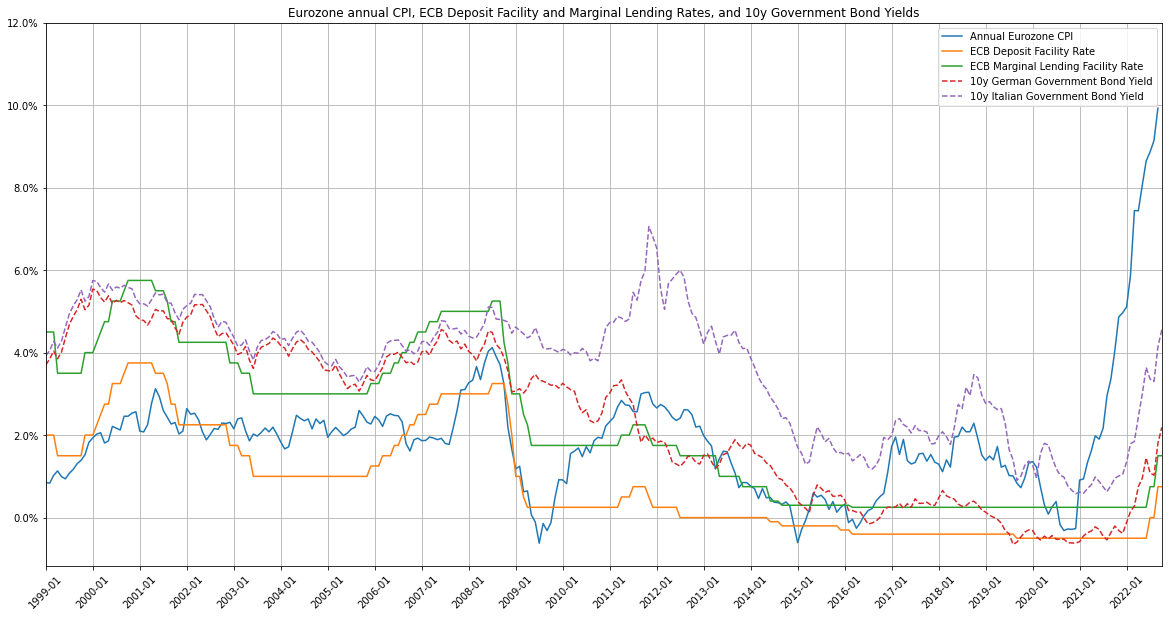

In [6]:
ax = cpi_ecbr_irtlt.iloc[:,:3].plot(figsize=(20,10), grid=True,
                        title='Eurozone annual CPI, ECB Deposit Facility and Marginal Lending Rates, and 10y Government Bond Yields',
                        xticks=cpi_ecbr_irtlt.index[::12], xlabel='', rot=45, yticks=np.arange(0, 14, 2))
cpi_ecbr_irtlt.iloc[:,3:].plot(ax=ax, linestyle='--', grid=True,
                        xticks=cpi_ecbr_irtlt.index[::12], xlabel='', rot=45, yticks=np.arange(0, 14, 2))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), cpi_ecbr_irtlt.index[::12])))

## Analyzing Euro Riskless Rate Curve
In this analysis I make use of the par yield implied by AAA-rated governmental bonds in the Euro area.

I use the following dataseries provided by the [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `irt_euryld_m` &mdash; Euro yield curves (monthly frequency). This series returns a MultiIndexed dataset from which multiple yields can be extraced: Instantaneous forward yield curve, Par yield curve, and Spot rate yield curve. In my analysis I use the Spor rate yield curve. The returned rates are presented using Annual percentage rates/yields and represent the average over all business days in a given month.
* `irt_st_m` &mdash; Euro EURIBOR rates (monthly frequency). EURIBOR uses the actual/360 daycount convention. This series returns a MultiIndexed dataset allowing to select different maturities. I only use the 1 month rates in this notebook as the spread between government bond rates and EURIBOR tends to increase with longer maturities. Rates returned represent the average over all business days in a given month.

And one dataset from [FRED](https://fred.stlouisfed.org):
* `ECBDFR` &mdash; ECB Deposit Facility Rate for Euro Area (daily frequency). I use it as proxy for overnight rate after downsampling to monthly frequency.

In [7]:
# Taking the last 3 months
euro_curves = web.DataReader('irt_euryld_m', 'eurostat', start=(report_end-MonthBegin(4)).date())
mm_rates = web.DataReader('irt_st_m', 'eurostat', start=(report_end-MonthBegin(4)).date())
ecb_deposit_rate = web.get_data_fred('ECBDFR', start=report_end-MonthBegin(4))

# Resample to monthly frequency
ecb_deposit_rate = ecb_deposit_rate.asfreq('D').resample('MS').mean()

In [8]:
# Making use of the MultiIndex columns to select par yields based on AAA-rate government bonds
euro_par_yields = euro_curves.sort_index(axis=1).loc[:,
                        ('Spot rate yield curve', 'AAA-rated euro area central government bonds')]
#'Spot rate yield curve', 'Par yield curve'
#'All euro area central government bonds', 'AAA-rated euro area central government bonds'

mm_rates = mm_rates.sort_index(axis=1).loc[:,
                        ('1-month rate', 'Euro area (EA11-1999, EA12-2001, EA13-2007, EA15-2008, EA16-2009, EA17-2011, EA18-2014, EA19-2015)')]

# Converting EURIBOR and ECB Deposit rates from actual/360 to actual/actual
leap_year_cond = lambda idx: idx.year % 4 == 0 & ((idx.year % 100 != 0) | (idx.year % 400 == 0))
mm_rates[leap_year_cond(mm_rates.index)] *= 366. / 360
mm_rates[np.invert(leap_year_cond(mm_rates.index))] *= 365. / 360
ecb_deposit_rate[leap_year_cond(ecb_deposit_rate.index)] *= 366. / 360
ecb_deposit_rate[np.invert(leap_year_cond(ecb_deposit_rate.index))] *= 365. / 360

# Getting rid of redundant level in the MultiIndex
euro_par_yields = euro_par_yields.droplevel([1,2], axis=1)

# Converting into an integer index based on matutities in years
euro_par_yields.columns = euro_par_yields.columns.map(lambda x: int(re.search(r'(\d+)\s\w+', x)[1]))
# mm_rates.columns = mm_rates.columns.map(lambda x: int(re.search(r'(\d+)-\w+', x)[1]))

# Rearranging columns in ascending order of maturities
euro_par_yields = euro_par_yields[euro_par_yields.columns.sort_values()]

In [9]:
euro_par_yields

MATURITY,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
TIME_PERIOD,,,,,,,,,,,,,,,,,,,,,
2022-07-01,0.2052%,0.4306%,0.5807%,0.7142%,0.8352%,0.9417%,1.0330%,1.1102%,1.1751%,1.2297%,...,1.5061%,1.5177%,1.5284%,1.5381%,1.5471%,1.5554%,1.5631%,1.5702%,1.5769%,1.5831%
2022-08-01,0.4084%,0.5986%,0.6890%,0.7705%,0.8530%,0.9322%,1.0041%,1.0671%,1.1213%,1.1677%,...,1.4058%,1.4159%,1.4251%,1.4335%,1.4413%,1.4484%,1.4551%,1.4612%,1.4670%,1.4723%
2022-09-01,1.1742%,1.4101%,1.5212%,1.6082%,1.6780%,1.7332%,1.7769%,1.8120%,1.8403%,1.8636%,...,1.9764%,1.9811%,1.9854%,1.9893%,1.9929%,1.9963%,1.9993%,2.0022%,2.0049%,2.0074%


In [10]:
date_now = euro_par_yields.index[-1].date()
date_1_mth_ago = date_now + relativedelta(months=-1)
date_2_mth_ago = date_now + relativedelta(months=-2)
offsets = list(map(lambda maturity: relativedelta(years=+maturity), euro_par_yields.columns))
monthly_offsets = [relativedelta(), relativedelta(months=+1)] #, relativedelta(months=+3), relativedelta(months=+6)]
offsets = monthly_offsets + offsets

In [11]:
# Define Euro yield curves
curve = curves.YieldCurve(date_now, offsets, np.append(
            np.append(ecb_deposit_rate.loc[str(mm_rates.index[-1])].to_numpy(), mm_rates.iloc[-1].to_numpy()),
            euro_par_yields.iloc[-1].to_numpy()))
curve_1_mth_ago = curves.YieldCurve(date_1_mth_ago, offsets, np.append(
            np.append(ecb_deposit_rate[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:], mm_rates[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:]),
            euro_par_yields[date_1_mth_ago:date_1_mth_ago+BDay()].to_numpy()[0,:]))
curve_2_mth_ago = curves.YieldCurve(date_2_mth_ago, offsets, np.append(
            np.append(ecb_deposit_rate[date_2_mth_ago:date_2_mth_ago+BDay()].to_numpy()[0,:], mm_rates[date_2_mth_ago:date_2_mth_ago+BDay()].to_numpy()[0,:]),
            euro_par_yields[date_2_mth_ago:date_2_mth_ago+BDay()].to_numpy()[0,:]))

In [12]:
curve_points = curve.get_curve_points(120)
curve_points_1_mth_ago = curve_1_mth_ago.get_curve_points(120)
curve_points_2_mth_ago = curve_2_mth_ago.get_curve_points(120)
curve_points.rename('Euro Yield Curve', inplace=True)
curve_points_1_mth_ago.rename(curve_points.name + ' (1 month prior)', inplace=True)
curve_points_2_mth_ago.rename(curve_points.name + ' (2 months prior)', inplace=True)

# Replacing indices for sake of better visualization
curve_points_1_mth_ago = curve_points_1_mth_ago.set_axis(curve_points.index)
curve_points_2_mth_ago = curve_points_2_mth_ago.set_axis(curve_points.index)
df = pd.concat([curve_points, curve_points_1_mth_ago, curve_points_2_mth_ago], axis=1)

In [13]:
df

,Euro Yield Curve,Euro Yield Curve (1 month prior),Euro Yield Curve (2 months prior)
2022-09-01,0.4309%,0.0000%,-0.4252%
2022-12-02,0.8021%,0.0808%,-0.1315%
2023-03-04,1.0114%,0.1902%,0.0445%
2023-06-04,1.1167%,0.3074%,0.1435%
2023-09-04,1.1762%,0.4117%,0.2060%
...,...,...,...
2051-08-30,2.0049%,1.4669%,1.5768%
2051-11-30,2.0055%,1.4683%,1.5784%
2052-03-01,2.0062%,1.4697%,1.5800%
2052-06-01,2.0068%,1.4710%,1.5815%


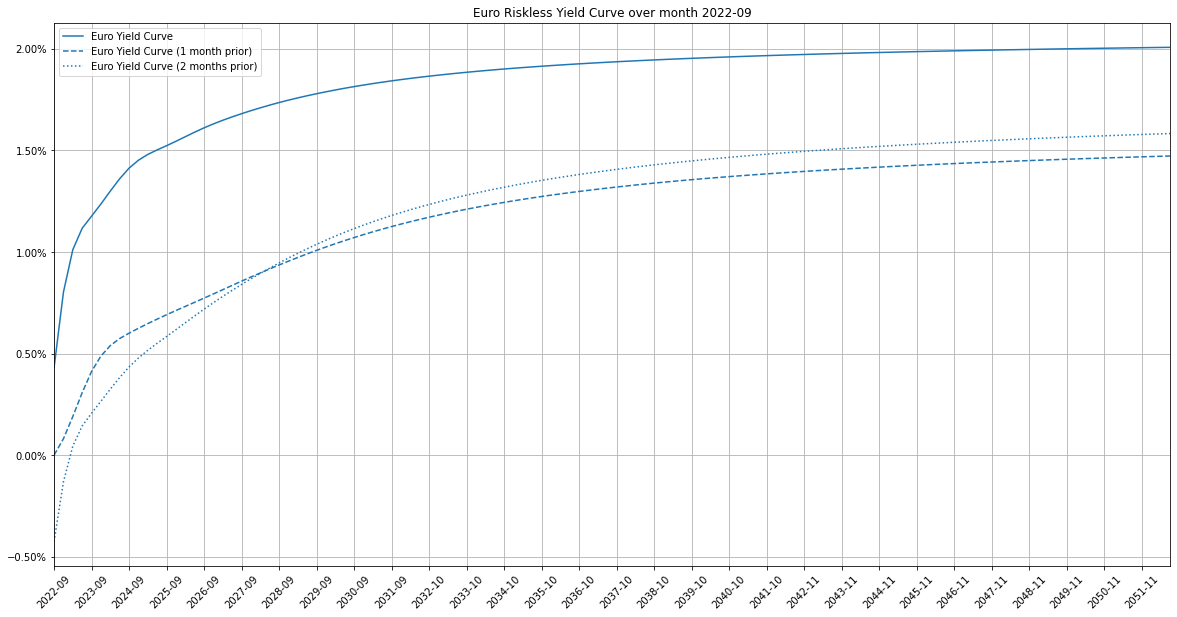

In [14]:
ax = df.iloc[:,0:1].plot(figsize=(20,10), grid=True,
             title='Euro Riskless Yield Curve over month ' + date_now.strftime('%Y-%m'),
             xlim=(df.index[0], df.index[-1]), xticks=df.index[::4], xlabel='', rot=45)
df.iloc[:,1:2].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle='--', color=['#1f77b4'])
df.iloc[:,2:3].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle=':', color=['#1f77b4'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), df.index[::4])))